In [38]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6

Found existing installation: kaggle 1.5.12
Uninstalling kaggle-1.5.12:
  Successfully uninstalled kaggle-1.5.12
     |████████████████████████████████| 1.6 MB 8.9 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     |████████████████████████████████| 58 kB 4.4 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72857 sha256=5f8471a814cc0ae9baf2fb61a1caaa7ec5919fe340f2bb4dabe882066f8f6d43
  Stored in directory: /root/.cache/pip/wheels/aa/e7/e7/eb3c3d514c33294d77ddd5a856bdd58dc9c1fabbed59a02a2b
Successfully built kaggle


In [2]:
import tensorflow
tensorflow.__version__

'2.6.0'

In [36]:
# Initialize the random number generator
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import gc
import glob
import os
import cv2

from zipfile import ZipFile
import skimage.io as io
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [39]:
#Connecting to Gdrive
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [40]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [41]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle
#Check the present working directory using pwd command

/content/gdrive/My Drive/Kaggle


## **1. Import the data. Analyse the dimensions of the data. Visualise the data.**

In [42]:
#Donwloading the data from Kaggle
!kaggle competitions download -c plant-seedlings-classification

 99% 1.68G/1.69G [00:12<00:00, 183MB/s]
100% 1.69G/1.69G [00:12<00:00, 146MB/s]


In [ ]:
#Lets list down the downloaded file
!ls

kaggle.json  plant-seedlings-classification.zip


We have Zip file, so extracting it using zipfile lib

In [ ]:
#Extract all zip files in the current directory
for file in glob.glob("*.zip"):
    # opening the zip file in READ mode
    with ZipFile(file, 'r') as zip:
    zip.printdir()
    zip.extractall()

In [ ]:
#As we extracted, lets delete the zip files
rm *.zip

In [ ]:
#Verify if any zip file exists
ls *zip

ls: cannot access '*zip': No such file or directory


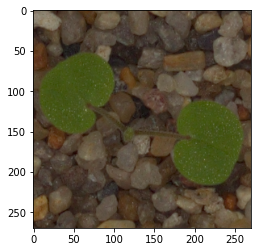

In [ ]:
#Lets view one sample image
imgs=[]
for file in glob.glob("./test/*.png"):
    # Read the image
    imgs.append(io.imread(file))
    break

plt.imshow(imgs[0])
plt.show()

In [7]:
#Load images dataset
def loadImagesData(glob_path):
    images = []
    names = []
    for img_path in glob.glob(glob_path):
        # load/resize images with cv2
        names.append(os.path.basename(img_path))
        images.append(cv2.resize(cv2.imread(img_path, cv2.IMREAD_COLOR),(256,256), interpolation=cv2.INTER_CUBIC))
    return (images,names)

In [8]:
#Label to images
trainData = {}
for label in os.listdir('./train/'):
    (images,names) = loadImagesData(f"./train/{label}/*.png")
    trainData[label] = images
    
print("train labels:", ",".join(trainData.keys()))

train labels: Black-grass,Charlock,Cleavers,Common Chickweed,Common wheat,Fat Hen,Loose Silky-bent,Maize,Scentless Mayweed,Shepherds Purse,Small-flowered Cranesbill,Sugar beet


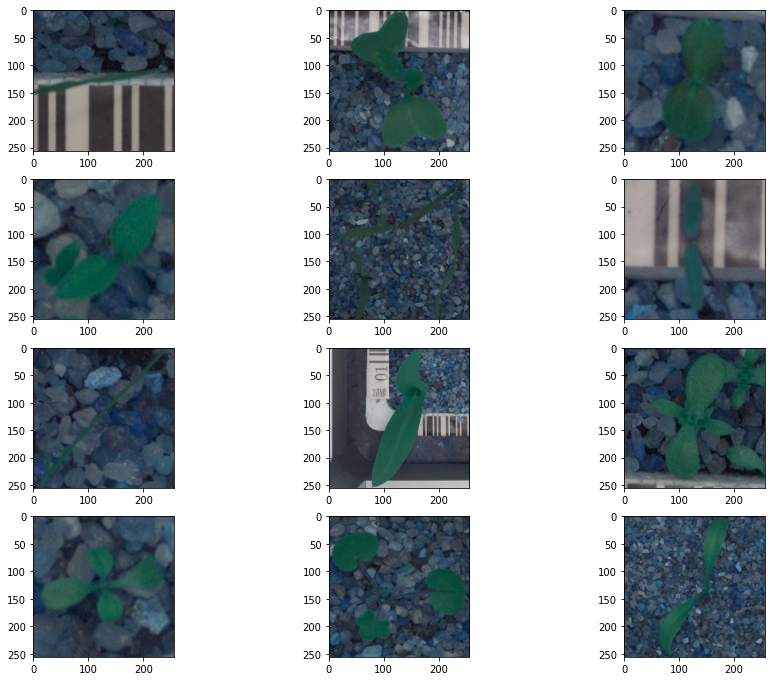

In [ ]:
#Random data
plt.figure(figsize=(15,15))
columns = 3
for i, label in enumerate(trainData.keys()):
    plt.subplot(len(trainData.keys()) / columns + 1, columns, i + 1)
    plt.imshow(trainData[label][0])
plt.show()

In [9]:
#Build datasets
trainList = []
for label in trainData.keys():
    for image in trainData[label]:
        trainList.append({
            'label': label,
            'data': image
        })
# shuffle dataset
random.shuffle(trainList)
# dataframe and display
train_df = pd.DataFrame(trainList)
gc.collect()
train_df.head()

,label,data
0,Loose Silky-bent,"[[[64, 81, 84], [64, 80, 83], [61, 78, 81], [5..."
1,Fat Hen,"[[[30, 40, 53], [24, 34, 48], [24, 32, 47], [2..."
2,Charlock,"[[[206, 204, 202], [205, 201, 199], [200, 198,..."
3,Sugar beet,"[[[59, 55, 56], [63, 61, 62], [64, 65, 64], [7..."
4,Small-flowered Cranesbill,"[[[37, 53, 95], [41, 53, 99], [28, 40, 88], [2..."


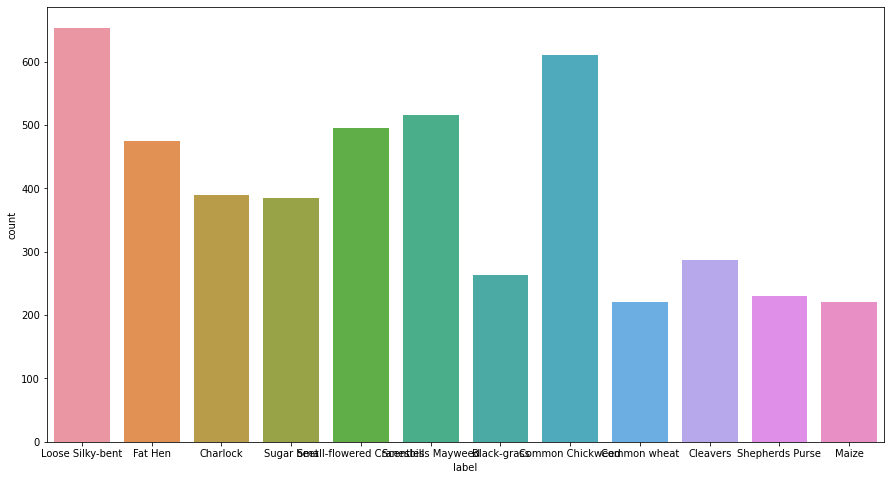

In [17]:
#Count plot on target
plt.figure(figsize=(15,8))
sns.countplot(train_df['label'])

- Few classes are under represented
- Overall dataset is slightly imbalanced
- Data Augumentation is needed

In [10]:
#Encode training data
data_stack = np.stack(train_df['data'].values)
dfloats = data_stack.astype(np.float32)
X = np.multiply(dfloats, 1.0 / 255.0)
X.shape

(4750, 256, 256, 3)

In [11]:
#Encode labels
le = LabelEncoder()
le.fit(list(trainData.keys()))
le_y = le.transform(train_df['label'])
# convert to keras categorical one-hot
y = np_utils.to_categorical(le_y)
y[0:2]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [12]:
#Split test/train data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=7)
print(X_train.shape,X_test.shape)

(3800, 256, 256, 3) (950, 256, 256, 3)


In [13]:
X_train.shape[1:]

(256, 256, 3)

In [14]:
#Data Augumentation
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    rotation_range=0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False)
datagen.fit(X_train)

# 2.1 Supervised learning algorithms

### SVM Model

In [ ]:
num_filters = 8
kernel_size = (10, 10)
input_shape = X_train.shape[1:]

model_svm = Sequential()
model_svm.add(Conv2D(num_filters, kernel_size, padding='same', input_shape=input_shape, activation = 'relu'))
model_svm.add(MaxPooling2D(pool_size=(2, 2)))
model_svm.add(Flatten())
model_svm.add(Dense(units = 12, activation = 'softmax'))

In [ ]:
model_svm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 8)       2408      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 8)       0         
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 12)                1572876   
Total params: 1,575,284
Trainable params: 1,575,284
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_feat = tensorflow.keras.models.Model(inputs=model_svm.input,outputs=model_svm.get_layer('dense').output)
feat_train = model_feat.predict(X_train)
feat_test = model_feat.predict(X_test)

In [ ]:
#SVM Model
svm = svm.SVC(kernel='poly')
svm.fit(feat_train,np.argmax(y_train,axis=1))

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
#Evaluate
SVMTrain = svm.score(feat_train,np.argmax(y_train,axis=1))
SVMTest = svm.score(feat_test,np.argmax(y_test,axis=1))
print('Train Accuracy',SVMTrain)
print('Test Accuracy',SVMTest)

Train Accuracy 0.20289473684210527
Test Accuracy 0.14421052631578948


In [ ]:
#Results DF for comparision
resultsDf = pd.DataFrame({'Method':['SVM'], 'Train': SVMTrain, 'Test': SVMTest})
resultsDf = resultsDf[['Method', 'Train','Test']]
resultsDf

,Method,Train,Test
0,SVM,0.202895,0.144211


### Decision Trees

In [ ]:
#Decision Tree method
model_dt = Sequential()
model_dt.add(Conv2D(num_filters, kernel_size, padding='same', input_shape=input_shape, activation = 'relu'))
model_dt.add(MaxPooling2D(pool_size=(2, 2)))
model_dt.add(Flatten())
model_dt.add(Dense(units = 12, activation = 'softmax'))

In [ ]:
#Model summary
model_dt.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 8)       2408      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 8)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                1572876   
Total params: 1,575,284
Trainable params: 1,575,284
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Training
model_feat = tensorflow.keras.models.Model(inputs=model_dt.input,outputs=model_dt.get_layer('dense_1').output)
feat_train = model_feat.predict(X_train)
feat_test = model_feat.predict(X_test)

In [ ]:
#Evaluate
dt = DecisionTreeClassifier(criterion = "entropy", random_state = 7,max_depth=25, min_samples_leaf=5)
dt.fit(feat_train,np.argmax(y_train,axis=1))
dtTrain=dt.score(feat_train,np.argmax(y_train,axis=1))
dtTest=dt.score(feat_test,np.argmax(y_test,axis=1))
print('Train Accuracy',dtTrain)
print('Test Accuracy',dtTest)

Train Accuracy 0.5413157894736842
Test Accuracy 0.11894736842105263


In [ ]:
#Results DF
tempResultsDf = pd.DataFrame({'Method':['Decision Tree'], 'Train': dtTrain, 'Test': dtTest})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'Train','Test']]
resultsDf

,Method,Train,Test
0,SVM,0.202895,0.144211
0,Decision Tree,0.541316,0.118947


### KNeighbour

In [ ]:
#KNN method
model_knn = Sequential()
model_knn.add(Conv2D(num_filters, kernel_size, padding='same', input_shape=input_shape, activation = 'relu'))
model_knn.add(MaxPooling2D(pool_size=(2, 2)))
model_knn.add(Flatten())
model_knn.add(Dense(units = 12, activation = 'softmax'))

In [ ]:
#Model summary
model_knn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 256, 256, 8)       2408      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 128, 8)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                1572876   
Total params: 1,575,284
Trainable params: 1,575,284
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Training
model_feat = tensorflow.keras.models.Model(inputs=model_knn.input,outputs=model_knn.get_layer('dense_2').output)
feat_train = model_feat.predict(X_train)
feat_test = model_feat.predict(X_test)

In [ ]:
#Evaluate
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(feat_train,np.argmax(y_train,axis=-1))
knnTrain = knn.score(feat_train,np.argmax(y_train,axis=1))
knnTest = knn.score(feat_test,np.argmax(y_test,axis=1))
print('Train Accuracy',knnTrain)
print('Test Accuracy',knnTest)

Train Accuracy 0.4702631578947368
Test Accuracy 0.12947368421052632


In [ ]:
#Results DF
tempResultsDf = pd.DataFrame({'Method':['KNeighbours'], 'Train': knnTrain, 'Test': knnTest})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'Train','Test']]
resultsDf

,Method,Train,Test
0,SVM,0.202895,0.144211
0,Decision Tree,0.541316,0.118947
0,KNeighbours,0.470263,0.129474


### Random Forest

In [ ]:
#Random Forest method
model_rt = Sequential()
model_rt.add(Conv2D(num_filters, kernel_size, padding='same', input_shape=input_shape, activation = 'relu'))
model_rt.add(MaxPooling2D(pool_size=(2, 2)))
model_rt.add(Flatten())
model_rt.add(Dense(units = 12, activation = 'softmax'))

In [ ]:
#Model summary
model_rt.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 256, 256, 8)       2408      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 128, 8)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 12)                1572876   
Total params: 1,575,284
Trainable params: 1,575,284
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Training
model_feat = tensorflow.keras.models.Model(inputs=model_rt.input,outputs=model_rt.get_layer('dense_3').output)
feat_train = model_feat.predict(X_train)
feat_test = model_feat.predict(X_test)

In [ ]:
#Evaluate
rt = RandomForestClassifier(n_estimators=5)
rt.fit(feat_train,np.argmax(y_train,axis=-1))

rtTrain = rt.score(feat_train,np.argmax(y_train,axis=1))
rtTest = rt.score(feat_test,np.argmax(y_test,axis=1))
print('Train Accuracy',rtTrain)
print('Test Accuracy',rtTest)


Train Accuracy 0.9328947368421052
Test Accuracy 0.1336842105263158


- RF is overfitting

- RandomForest performs better obvisouly without setting max_depth. Lets set it to 10 & see.

In [ ]:
#Random Forest method tuning
rt = RandomForestClassifier(n_estimators=10, max_depth=10)
rt.fit(feat_train,np.argmax(y_train,axis=-1))
rtScore=rt.score(feat_train,np.argmax(y_train,axis=1))
rtTrain = rt.score(feat_train,np.argmax(y_train,axis=1))
rtTest = rt.score(feat_test,np.argmax(y_test,axis=1))
print('Train Accuracy',rtTrain)
print('Test Accuracy',rtTest)

Train Accuracy 0.6573684210526316
Test Accuracy 0.1705263157894737


In [ ]:
#Results DF
tempResultsDf = pd.DataFrame({'Method':['Random Forest'], 'Train': rtTrain, 'Test': rtTest})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'Train','Test']]
resultsDf

,Method,Train,Test
0,SVM,0.202895,0.144211
0,Decision Tree,0.541316,0.118947
0,KNeighbours,0.470263,0.129474
0,Random Forest,0.657368,0.170526


- RandomForest method is fairly better than the other Supervised Learning image classifications.

## 2.2 Neural networks

In [20]:
#ANN Model
model_ann = Sequential()
model_ann.add(Dense(16, input_shape=X_train.shape[1:], activation='relu'))
model_ann.add(Dropout(0.4))
model_ann.add(Dense(32, activation='relu'))
model_ann.add(Dropout(0.6))
model_ann.add(Flatten())
model_ann.add(Dense(12, activation='softmax'))

model_ann.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model_ann.fit(X_train, y_train,epochs=50,batch_size=32,validation_data=(X_test,y_test))

Epoch 1/50
119/119 [==============================] - 16s 121ms/step - loss: 5.6341 - accuracy: 0.2892 - val_loss: 2.0485 - val_accuracy: 0.3063
Epoch 2/50
119/119 [==============================] - 14s 117ms/step - loss: 1.3218 - accuracy: 0.5639 - val_loss: 1.6408 - val_accuracy: 0.4316
Epoch 3/50
119/119 [==============================] - 14s 117ms/step - loss: 0.9695 - accuracy: 0.6821 - val_loss: 1.5018 - val_accuracy: 0.4695
Epoch 4/50
119/119 [==============================] - 14s 117ms/step - loss: 0.7468 - accuracy: 0.7608 - val_loss: 1.5730 - val_accuracy: 0.4600
Epoch 5/50
119/119 [==============================] - 14s 117ms/step - loss: 0.5673 - accuracy: 0.8211 - val_loss: 1.5036 - val_accuracy: 0.4884
Epoch 6/50
119/119 [==============================] - 14s 117ms/step - loss: 0.4941 - accuracy: 0.8408 - val_loss: 1.7048 - val_accuracy: 0.4716
Epoch 7/50
119/119 [==============================] - 14s 117ms/step - loss: 0.3598 - accuracy: 0.8942 - val_loss: 1.6680 - val_ac

In [21]:
#Evaluate the Test set using saved model
Ann_Test = model_ann.evaluate(X_test,y_test,verbose=0)[1]
Ann_Train = model_ann.evaluate(X_train,y_train,verbose=0)[1]
print("Train Accuracy",Ann_Train)
print("Test Accuracy",Ann_Test)

Train Accuracy 0.9431579113006592
Test Accuracy 0.5326315760612488


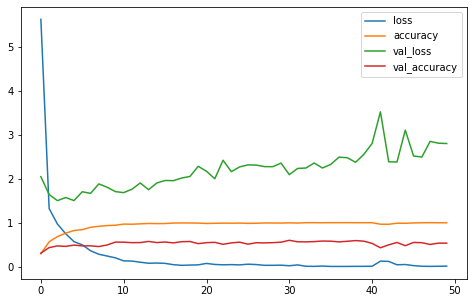

In [23]:
#Loss vs Epoch
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

- The ANN Model is clearly over-fitting
- After 10-15 epochs, training accuracy & loss are saturated and reached 90+ accuracy.
- Val loss came down in first few epochs & started going up again. 
- Val accuracy isn't improved much after 10+ epochs.

## 2.3  Simple CNN

In [15]:
#CNN model
model_cnn = Sequential()
model_cnn.add(Conv2D(16,(5,5),padding='valid',input_shape = (X_train.shape[1:])))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'valid'))
model_cnn.add(Dropout(0.4))
model_cnn.add(Conv2D(32,(5,5),padding='valid'))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'valid'))
model_cnn.add(Dropout(0.6))
model_cnn.add(Conv2D(64,(5,5),padding='valid'))
model_cnn.add(Activation('relu'))
model_cnn.add(Dropout(0.8))
model_cnn.add(Flatten())
model_cnn.add(Dense(12))
model_cnn.add(Activation('softmax'))

batch_size = 20
epochs= 50

optimizer = tensorflow.keras.optimizers.Adamax(lr = 0.001, decay = 1e-7)

In [16]:
model_cnn.compile(loss = 'categorical_crossentropy',optimizer = optimizer, metrics = ['accuracy'])

history = model_cnn.fit(X_train,y_train,steps_per_epoch = int(len(X_train)/batch_size),epochs=epochs,validation_data=(X_test,y_test))

Epoch 1/50
190/190 [==============================] - 22s 28ms/step - loss: 2.4308 - accuracy: 0.1626 - val_loss: 2.1975 - val_accuracy: 0.2968
Epoch 2/50
190/190 [==============================] - 5s 24ms/step - loss: 1.7208 - accuracy: 0.4074 - val_loss: 1.5510 - val_accuracy: 0.4937
Epoch 3/50
190/190 [==============================] - 5s 24ms/step - loss: 1.3603 - accuracy: 0.5274 - val_loss: 1.3103 - val_accuracy: 0.5484
Epoch 4/50
190/190 [==============================] - 5s 24ms/step - loss: 1.1774 - accuracy: 0.6024 - val_loss: 1.2891 - val_accuracy: 0.5337
Epoch 5/50
190/190 [==============================] - 5s 24ms/step - loss: 1.0768 - accuracy: 0.6387 - val_loss: 1.1552 - val_accuracy: 0.6032
Epoch 6/50
190/190 [==============================] - 5s 24ms/step - loss: 0.9839 - accuracy: 0.6679 - val_loss: 1.0677 - val_accuracy: 0.6821
Epoch 7/50
190/190 [==============================] - 5s 24ms/step - loss: 0.9137 - accuracy: 0.6892 - val_loss: 0.9996 - val_accuracy: 0.682

In [17]:
#Evaluate
Cnn_Test = model_cnn.evaluate(X_test,y_test,verbose=0)[1]
Cnn_Train = model_cnn.evaluate(X_train,y_train,verbose=0)[1]
print("Train Accuracy",Cnn_Train)
print("Test Accuracy",Cnn_Test)

Train Accuracy 0.9997368454933167
Test Accuracy 0.7547368407249451


- The CNN mode is clearly over-fitting too.
- This is much better than ANN model on val accuracy basis
- So to balance it out, we will have to build complex CNN model with more **regularization, dropout methods.**

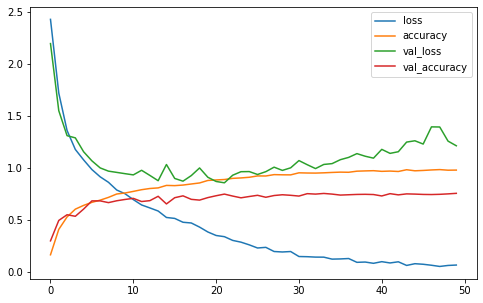

In [19]:
#Loss vs Epoch
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

- After around 20 epochs, val loss is going up again whereas training loss is still coming down.
- We will have to use CallBacks too when building complex CNN model

## Lets build complex CNN model with regularization methos to reduce over-fitting

# Complex CNN Model

In [25]:
#Complex CNN Model

image_size=256
model = tensorflow.keras.models.Sequential()

model.add(tensorflow.keras.layers.InputLayer(input_shape=(image_size,image_size,3,)))
model.add(tensorflow.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(tensorflow.keras.layers.MaxPool2D(pool_size = (2,2)))
model.add(tensorflow.keras.layers.BatchNormalization())
model.add(tensorflow.keras.layers.Conv2D(64, kernel_size=(3,3), strides = (1,1),activation='relu'))
model.add(tensorflow.keras.layers.MaxPool2D(pool_size = (2,2)))
model.add(tensorflow.keras.layers.BatchNormalization())
model.add(tensorflow.keras.layers.Conv2D(128, kernel_size=(3,3), strides = (1,1), activation='relu'))
model.add(tensorflow.keras.layers.MaxPool2D(pool_size = (2,2)))
model.add(tensorflow.keras.layers.BatchNormalization())
model.add(tensorflow.keras.layers.Conv2D(128, kernel_size=(3,3), strides = (1,1), activation='relu'))
model.add(tensorflow.keras.layers.MaxPool2D(pool_size = (2,2)))
model.add(tensorflow.keras.layers.GlobalMaxPool2D())
model.add(tensorflow.keras.layers.Flatten())
model.add(tensorflow.keras.layers.Dense(128, activation='relu'))
model.add(tensorflow.keras.layers.Dropout(0.2))
model.add(tensorflow.keras.layers.Dense(64, activation='relu'))
model.add(tensorflow.keras.layers.BatchNormalization())

model.add(tensorflow.keras.layers.Dense(12, activation='softmax'))

In [26]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Save the Best model at epoch level based on Val accuracy basis

In [27]:
#Save the best model to the checkpoint
checkpoint = tensorflow.keras.callbacks.ModelCheckpoint('plant_classifier.h5', #where to save the model
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose = 1)

In [28]:
#Train model
batch_size = 20
history = model.fit_generator(datagen.flow(X_train, y_train,
                            batch_size=batch_size),
                            steps_per_epoch= (X_train.shape[0] // batch_size),
                            epochs = 50,
                            validation_data=(X_test, y_test),
                            callbacks = [checkpoint]
                           )

Epoch 1/50
190/190 [==============================] - 46s 236ms/step - loss: 2.1774 - accuracy: 0.2834 - val_loss: 2.8351 - val_accuracy: 0.1358

Epoch 00001: val_accuracy improved from -inf to 0.13579, saving model to plant_classifier.h5
Epoch 2/50
190/190 [==============================] - 43s 229ms/step - loss: 1.5294 - accuracy: 0.4834 - val_loss: 2.9609 - val_accuracy: 0.1453

Epoch 00002: val_accuracy improved from 0.13579 to 0.14526, saving model to plant_classifier.h5
Epoch 3/50
190/190 [==============================] - 44s 229ms/step - loss: 1.2166 - accuracy: 0.5845 - val_loss: 2.0910 - val_accuracy: 0.3084

Epoch 00003: val_accuracy improved from 0.14526 to 0.30842, saving model to plant_classifier.h5
Epoch 4/50
190/190 [==============================] - 44s 229ms/step - loss: 0.9598 - accuracy: 0.6703 - val_loss: 4.6373 - val_accuracy: 0.2053

Epoch 00004: val_accuracy did not improve from 0.30842
Epoch 5/50
190/190 [==============================] - 43s 228ms/step - loss:

In [29]:
#Evaluate
Cnn2_Test = model.evaluate(X_test,y_test,verbose=0)[1]
Cnn2_Train = model.evaluate(X_train,y_train,verbose=0)[1]
print("Train Accuracy",Cnn2_Train)
print("Test Accuracy",Cnn2_Test)

Train Accuracy 0.9447368383407593
Test Accuracy 0.8989473581314087


- Better model it is. Decent Test score too.
- We avoided over-fitting

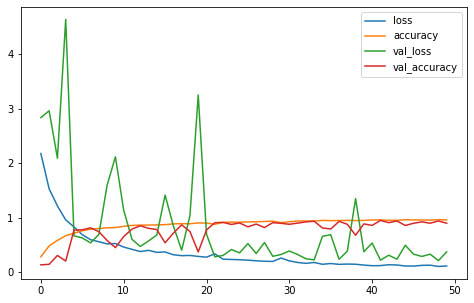

In [30]:
#Loss vs Epochs
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

- Val loss is very fluctuating but kind of going down as no.of epochs go high


# 4. Pickle the best performing model. 

#### One model is already saved while being trained
#### Lets save the previous CNN1 method manually

In [20]:
#Save the model
model_cnn.save('./best_cnn_model2')

print("\nReload the pickled model")
Pickled_CNN2 = tensorflow.keras.models.load_model('./best_cnn_model2')

#Predcting the scores using Loaded Model
print(Pickled_CNN1.evaluate(X_train,y_train))
print(Pickled_CNN1.evaluate(X_test,y_test))

INFO:tensorflow:Assets written to: ./best_cnn_model2/assets

Reload the pickled model
119/119 [==============================] - 2s 15ms/step - loss: 0.0051 - accuracy: 0.9997
[0.00506338058039546, 0.9997368454933167]
30/30 [==============================] - 0s 15ms/step - loss: 1.2129 - accuracy: 0.7547
[1.212925672531128, 0.7547368407249451]


#### Reloading the best model CNN2 saved using CallBacks

In [31]:
#Reloading
print("\nReload the pickled model")
Pickled_CNN2 = tensorflow.keras.models.load_model('./plant_classifier.h5')

#Predcting the scores using Loaded Model
print(Pickled_CNN2.evaluate(X_train,y_train))
print(Pickled_CNN2.evaluate(X_test,y_test))


Reload the pickled model
119/119 [==============================] - 2s 19ms/step - loss: 0.0481 - accuracy: 0.9850
[0.04808950051665306, 0.9850000143051147]
30/30 [==============================] - 1s 19ms/step - loss: 0.2219 - accuracy: 0.9505
[0.2218797355890274, 0.9505262970924377]


# 5 Predicting the image1

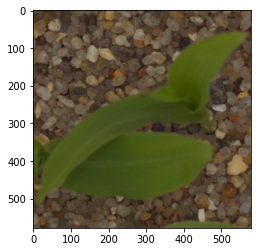

In [32]:
import skimage.io as io
# Read the image
img = io.imread('./Predict.png')

plt.imshow(img)
plt.show()

In [ ]:
#Predict using CNN Model
img = img.astype('float32')
img = cv2.resize(img,(256,256),3)
img = img.reshape(1, 256, 256, 3)
y_pred = Pickled_CNN1.predict(img)
print("Predicted label:", y_pred.argmax())
print("Softmax Outputs:", y_pred)
class_names = list(trainData.keys())
print("Predicted class name: ",class_names[y_pred.argmax()])

Predicted label: 7
Softmax Outputs: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Predicted class name:  Maize


In [33]:
#Predict using Reloaded Model
img = img.astype('float32')
img = cv2.resize(img,(256,256),3)
img = img.reshape(1, 256, 256, 3)
y_pred = Pickled_CNN2.predict(img)
print("Predicted label:", y_pred.argmax())
print("Softmax Outputs:", y_pred)
class_names = list(trainData.keys())
print("Predicted class name: ",class_names[y_pred.argmax()])

Predicted label: 8
Softmax Outputs: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
Predicted class name:  Scentless Mayweed


- Intersting, two different predictions by two models

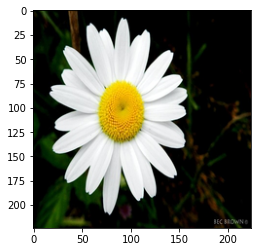

In [34]:
# Read the image
img = io.imread('./Prediction - Flower.jpg')

plt.imshow(img)
plt.show()

In [35]:
#Predict above image & its label
img = img.astype('float32')
img = cv2.resize(img,(256,256),3)
img = img.reshape(1, 256, 256, 3)
y_pred = Pickled_CNN1.predict(img)
print("Predicted label:", y_pred.argmax())
print("Softmax Outputs:", y_pred.round(2))
class_names = list(trainData.keys())
print("Predicted class name: ",class_names[y_pred.argmax()])

Predicted label: 5
Softmax Outputs: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
Predicted class name:  Fat Hen


In [ ]:
#Predict above image & its label
img = img.astype('float32')
img = cv2.resize(img,(256,256),3)
img = img.reshape(1, 256, 256, 3)
y_pred = Pickled_Load2.predict(img)
print("Predicted label:", y_pred.argmax())
print("Softmax Outputs:", y_pred.round(2))
class_names = list(trainData.keys())
print("Predicted class name: ",class_names[y_pred.argmax()])

Predicted label: 8
Softmax Outputs: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
Predicted class name:  Scentless Mayweed


## Predicting all New Images from Test folder

In [ ]:
#Load test image data from test folder
(test_images, test_names) = loadImagesData(f"./test/*.png")
data_stack = np.stack(test_images)
dfloats = data_stack.astype(np.float32)
X_new = np.multiply(dfloats, 1.0 / 255.0)

In [ ]:
#Predicting New Images
predicted = np.argmax(model.predict(X_new), axis=1)
predicted_labels = le.inverse_transform(predicted)
submission_df = pd.DataFrame({'file':test_names,'species':predicted_labels})
submission_df.to_csv('submission.csv', index=False)
len(submission_df)

794

# 5. Conclusions & Comparing the Model performances

### About Given Data:
- Limited data (4750 training & 794 test(no labels)) & we've used 20% training images as validation (test) set.
- Has 12 classes, few are under-represented. So Data augumentation is used.
- Images are captured under different lighting conditions & has different aspect ratio/angle.
- So resizing them to 256 is very intensive computationally. Tried with 128, 192 sizes, but couldn't perform well.
- Have different shapes of images & no concerete object placements.
- Image pre-processing is key step too as we have to supress unwanted distortions & enhance the wanted feature space.

### Comparing Models:

##### Supervised Methods:

- resultsDF has all accuracy details of supervised learning algorithams.
- We know feature extraction is very key task in image classification, as we have images with variety shapes/object positions/lighting conditions, Supervised alogorithams failed to perform this task. Thats why all supervised algorithams yield too low val score.
- Decision Tree/Random Forest are tree based(hierachical rule) methods, so did decent job on train images & obviosuly failed to do same on new images.
- SVM is hyperplane based/ KNN is distance based methods. As we see, its difficult to differentiate the image classes as data points, looks more unclear under different sizes/shapes/lighting conditions. Thats why these two methonds failed to do well both on training/testing sets.
- Overall image segmentation is tough for supervised methods, so failed to identifying the object positions in order to differentiate the classes.

##### Neural Networks:

- ANN is over-fitting 
- As no.of epochs go high, ww know its too many trainable parameters, can't afford complex ANN here, yet it did decent job because the dataset is not too large
- When tweaking learning rate, optimizers, ANN model too did good job on such datasets.
- Even with higher the no.of epochs,ANN val loss is also spiking up,over-fitting
- Since data is vary, ANN fails to do feature extraction well compared to CNN

##### CNN:

- CNN outperformed all other methods
- A simple CNN is over-fitting & as we added more regularization methods + Maxpooling+ Global Pooling+ Dropout, it achieved very good score on both train & test datasets.
- CNN directly extracts spatial features from input image, and with few trainable parameters, CNN is powerfull on this kind of datasets.
- And CNN does better feature extraction & segmentation compared to all previous methods. So CNN is prefered on such datasets.



############## END of the notebook ###############